ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded on: cuda:0


Running Inference: 100%|██████████| 1500/1500 [50:30<00:00,  2.02s/it]



Inference Complete!
Total Samples: 1500
Total Time: 3030.35 sec
Inference Latency: 2.020 sec/sample
Throughput: 0.49 samples/sec
Memory Usage (RSS): 521.19 MB
Incorrect predictions: 564 / 1500
                                               review sentiment  \
3   "I was taking 30mg of temazepam. It&#039;s the...  positive   
5   "A LOT of trouble with stomach issues; diarrhe...   neutral   
7   "I used it about 2 months ago for bacterial va...   neutral   
10  "Had the Prevnar 13 yesterday. Couldn&#039;t s...   neutral   
12  "I had basically perfect skin until my freshma...   neutral   
14  "Helped depression a lot, but side effects  we...  positive   
17  "I used this drug for the sole purpose to cont...   neutral   
18  "I have had major stomach issues all of my lif...  positive   
19  "Don&#039;t take it in the morning or you may ...  positive   
30  "I have been on this pill for almost a month n...  negative   

   predicted_sentiment  
3             negative  
5             nega

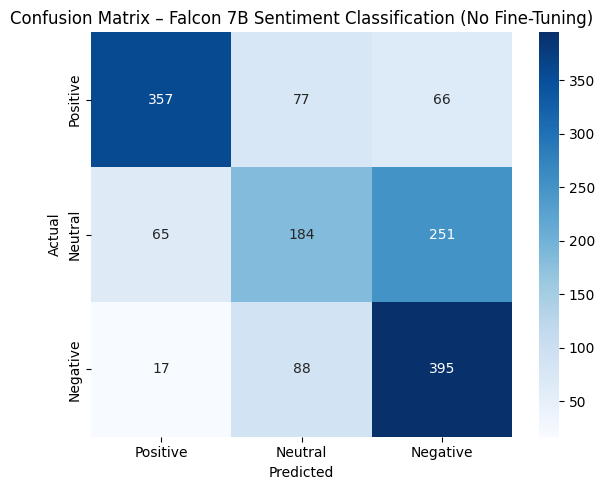

In [ ]:
# Core transformers + LLM tools
!pip install -q transformers accelerate

# Dataset loader
!pip install -q datasets

# Evaluation and performance tracking
!pip install -q scikit-learn pandas matplotlib seaborn

# Memory tracking and progress
!pip install -q psutil tqdm

# Fix the fsspec version for gcsfs compatibility
!pip install -q fsspec==2025.3.2

# Phase 1: Data Preparation
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset from Hugging Face
dataset = load_dataset("Zakia/drugscom_reviews", split="train")

# Convert to pandas DataFrame for easier manipulation
df = dataset.to_pandas()

# Step 2: Clean and preprocess the data
# Keep only the relevant columns: 'review' and 'rating'
df = df[['review', 'rating']].dropna()

# Convert rating (1–10) into sentiment labels
def convert_rating_to_sentiment(rating):
    if rating <= 4:
        return 'negative'
    elif rating >= 7:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(convert_rating_to_sentiment)

# Step 3: Split the data into 80% test (for now) and 20% holdout
df_train, df_holdout = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

# Step 4: Sample 500 reviews per sentiment for balanced test set
df_sampled = pd.concat([
    df_train[df_train['sentiment'] == 'positive'].sample(500, random_state=42),
    df_train[df_train['sentiment'] == 'neutral'].sample(500, random_state=42),
    df_train[df_train['sentiment'] == 'negative'].sample(500, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Load Falcon 7B
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    trust_remote_code=True
)
model.eval()
print(f"Model loaded on: {model.device}")

# Step 6: Inference with Improved Prompt
import time
import psutil
from tqdm import tqdm
import re

# Improved prompt with few-shot examples
def create_instruction_prompt(review):
    return f"""You are a sentiment classifier for drug reviews. Classify the sentiment of the following drug review as one of: Positive, Neutral, or Negative. Here are some examples to guide you:

Example 1:
Review: "This drug worked wonders for me, I feel so much better!"
Sentiment: Positive

Example 2:
Review: "It was okay, nothing special, but no side effects."
Sentiment: Neutral

Example 3:
Review: "Terrible experience, I had severe side effects."
Sentiment: Negative

Now classify this review:
Review: "{review}"

Answer: """

# Keyword-based fallback for sentiment inference
def infer_sentiment_from_text(text):
    positive_keywords = ["good", "great", "excellent", "positive", "wonderful", "helpful"]
    negative_keywords = ["bad", "terrible", "awful", "negative", "severe", "side effects"]
    text_lower = text.lower()
    if any(keyword in text_lower for keyword in positive_keywords):
        return "positive"
    elif any(keyword in text_lower for keyword in negative_keywords):
        return "negative"
    else:
        return "neutral"

# Inference loop
predictions = []
start_time = time.time()
process = psutil.Process()
valid_labels = ["positive", "neutral", "negative"]

# Record memory before
mem_before = process.memory_info().rss / (1024 ** 2)

for prompt in tqdm(df_sampled['review'].apply(create_instruction_prompt), desc="Running Inference"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,  # Increased to allow full label generation
            do_sample=True,  # Enable sampling for diversity
            temperature=0.7,  # Lower temperature for more focused outputs
            top_k=50,  # Top-k sampling for diversity
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    # Extract sentiment
    # Remove the prompt part from the generated text
    generated_text = generated_text.replace(prompt.lower(), "").strip()
    # Look for valid labels in the generated text
    for label in valid_labels:
        if label in generated_text:
            predictions.append(label)
            break
    else:
        # If no valid label is found, infer sentiment from the generated text
        predictions.append(infer_sentiment_from_text(generated_text))

# Record memory after
mem_after = process.memory_info().rss / (1024 ** 2)
end_time = time.time()

# Step 7: Runtime metrics
total_time = end_time - start_time
latency = total_time / len(df_sampled)
throughput = len(df_sampled) / total_time
memory_used = mem_after - mem_before

# Step 8: Output runtime stats
print(f"\nInference Complete!")
print(f"Total Samples: {len(df_sampled)}")
print(f"Total Time: {total_time:.2f} sec")
print(f"Inference Latency: {latency:.3f} sec/sample")
print(f"Throughput: {throughput:.2f} samples/sec")
print(f"Memory Usage (RSS): {memory_used:.2f} MB")

# Step 9: Save predictions
df_sampled['predicted_sentiment'] = predictions

# Step 10: Show incorrect predictions for analysis
df_errors = df_sampled[df_sampled['sentiment'] != df_sampled['predicted_sentiment']]
print(f"Incorrect predictions: {len(df_errors)} / {len(df_sampled)}")
print(df_errors[['review', 'sentiment', 'predicted_sentiment']].head(10))

# Step 11: Generate performance report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ground truth and predictions
y_true = df_sampled['sentiment']
y_pred = df_sampled['predicted_sentiment']

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
labels = ["Positive", "Neutral", "Negative"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Falcon 7B Sentiment Classification (No Fine-Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()